## Setup

In [ ]:
# !pip3 uninstall -y numpy torch torchvision matplotlib timm monai
# !pip cache purge
# !pip3 install torch torchvision matplotlib numpy timm monai
# !pip3 install monai timm

In [ ]:
# !pip3 install torch torchvision matplotlib numpy timm monai
# !pip3 uninstall -y numpy

In [1]:
!pip3 install monai onnx openvino onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3

## Imports

In [1]:
import os
import torch
import timm
import timm.optim
import timm.scheduler

from torch import nn
from torch.utils.data import random_split
from sklearn.metrics import classification_report
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
from PIL import Image
import PIL

from timm.data import create_dataset, create_loader
from timm.data.transforms_factory import create_transform
from monai.apps import download_and_extract
from openvino.runtime import Core
import onnxruntime

<frozen importlib.util>:262: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.


In [ ]:
# Check setup
# !python -V
# !nvidia-smi
# print("Using torch", torch.__version__)
# print("Torchvision", torchvision.__version__)

# torch.cuda.device_count()
# torch.version.cuda
# !nvcc -V
# torch.backends.cudnn.version()

## Setup dataset

In [2]:
# create directory
directory = "./Data"
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = directory
print(root_dir)

./Data


In [3]:
# download dataset
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:01, 39.9MB/s]                            

2025-04-04 05:42:15,357 - INFO - Downloaded: Data/MedNIST.tar.gz


2025-04-04 05:42:15,472 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-04-04 05:42:15,473 - INFO - Writing into directory: ./Data.


In [4]:
# dataset info
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


In [5]:
# split dataset
train_transform = create_transform(224, is_training=True, auto_augment='rand-m9-mstd0.5')
# train_transform = create_transform(224, is_training=True)
test_transform = create_transform(224)

dataset = create_dataset('', root_dir, transform=None)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size])

train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

## Setup parameters

In [6]:
batch_size=16
num_epochs=5
num_epoch_repeat = num_epochs//2
loss_fn = nn.CrossEntropyLoss()

train_on_gpu = torch.cuda.is_available()
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

## Setup timm model

In [7]:
model = timm.create_model('resnet18', pretrained=True, num_classes=6, exportable=True)
# model = timm.create_model('resnet18', pretrained=True, num_classes=6, exportable=True, global_pool='avgmax')
input_size = model.pretrained_cfg['input_size']
try:
    # only works if gpu present on machine
    train_dataloader = create_loader(train_data, input_size, batch_size, is_training=True)
except:
    train_dataloader = create_loader(train_data, input_size, batch_size, is_training=True,use_prefetcher=False)

try:
    # only works if gpu present on machine
    test_dataloader = create_loader(test_data, input_size, batch_size)
except:
    test_dataloader = create_loader(test_data, input_size, batch_size, use_prefetcher=False)

image_batch, label_batch = next(iter(train_dataloader))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [8]:
optimizer = timm.optim.AdamP(model.parameters(), lr=0.01)
# optimizer = timm.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
# optimizer = timm.optim.AdaBelief(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)
scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            warmup_lr_init=0.01,
                                            warmup_t=3,
                                            cycle_limit=num_epoch_repeat+1
                                           )

## Freeze all layers but the last

In [9]:
for param in model.parameters():
    param.requires_grad = False


for param in model.fc.parameters():
    param.requires_grad = True

## Setup training functions

In [10]:
# def train_step(model: torch.nn.Module,
#                dataloader: torch.utils.data.DataLoader,
#                loss_fn: torch.nn.Module,
#                optimizer: torch.optim.Optimizer,
#                device: torch.device,
#                epoch: int,
#                scheduler: Any) -> Tuple[float, float]:
def train_stepnew(model, dataloader, loss_fn, optimizer, device, epoch, scheduler):
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    num_steps_per_epoch = len(dataloader)
    num_updates = epoch * num_steps_per_epoch

    lrs = []

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        #new added for timm
        if scheduler is not None:
          num_updates += 1
          scheduler.step_update(num_updates=num_updates)
          lrs.append(optimizer.param_groups[0]["lr"])

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc, lrs

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# def train(model: torch.nn.Module,
#           train_dataloader: torch.utils.data.DataLoader,
#           test_dataloader: torch.utils.data.DataLoader,
#           optimizer: torch.optim.Optimizer,
#           loss_fn: torch.nn.Module,
#           epochs: int,
#           device: torch.device) -> Dict[str, List]:
def trainnew(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, scheduler):
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": [],
               "all_lrs": []}

    # Loop through training and testing steps for a number of epochs

    # Make sure model on target device
    model.to(device)

    all_lrs=[]

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # train_loss, train_acc = train_step(model=model,
        #                                   dataloader=train_dataloader,
        #                                   loss_fn=loss_fn,
        #                                   optimizer=optimizer,
        #                                   device=device)
        train_loss, train_acc, lrs = train_stepnew(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device,
                                          epoch=epoch,
                                          scheduler=scheduler)

        if scheduler is not None:
          all_lrs.extend(lrs)
          scheduler.step(epoch + 1)

        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["all_lrs"].append(all_lrs)

    # Return the filled results at the end of the epochs
    return results

## Train model

In [11]:
# Start the timer
start_time = timer()

# Setup training and save the results
# results = train(model=model,
#                        train_dataloader=train_dataloader,
#                        test_dataloader=test_dataloader,
#                        optimizer=optimizer,
#                        loss_fn=loss_fn,
#                        epochs=num_epochs,
#                        device=device)
results = trainnew(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=num_epochs,
                       device=device,
                       scheduler=scheduler)
# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3037 | train_acc: 0.8301 | test_loss: 0.3325 | test_acc: 0.8265
Epoch: 2 | train_loss: 0.2705 | train_acc: 0.8470 | test_loss: 0.3371 | test_acc: 0.8268
Epoch: 3 | train_loss: 0.2668 | train_acc: 0.8524 | test_loss: 0.2279 | test_acc: 0.8501
Epoch: 4 | train_loss: 0.2417 | train_acc: 0.8674 | test_loss: 0.2534 | test_acc: 0.8281
Epoch: 5 | train_loss: 0.2597 | train_acc: 0.8573 | test_loss: 0.3374 | test_acc: 0.8244
[INFO] Total training time: 680.491 seconds


## Plots and info about model

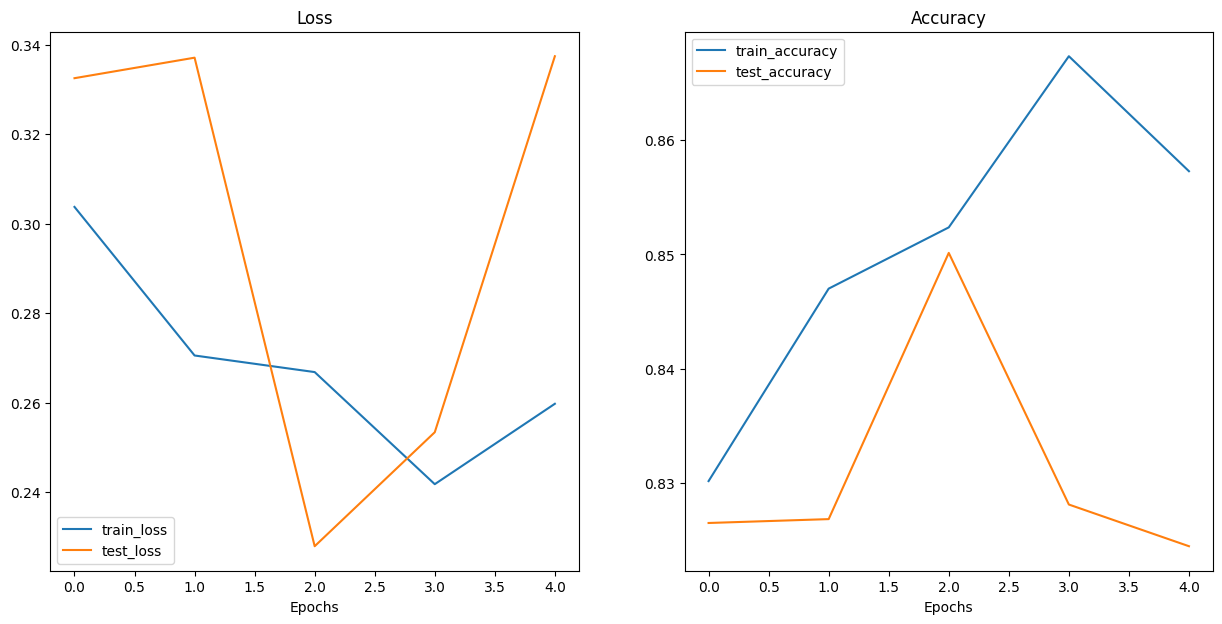

In [12]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(results)

In [13]:
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_dataloader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.0000    0.0000    0.0000      1996
   BreastMRI     0.9994    0.9944    0.9969      1775
         CXR     0.4970    1.0000    0.6640      1995
     ChestCT     0.9990    0.9833    0.9911      2032
        Hand     0.9861    0.9852    0.9857      2023
      HeadCT     0.9924    1.0000    0.9962      1970

    accuracy                         0.8244     11791
   macro avg     0.7457    0.8271    0.7723     11791
weighted avg     0.7417    0.8244    0.7688     11791



## Model export and inference Optimization

In [14]:
model.eval()

x = image_batch
torch_out = model(x)

# Export the model
torch.onnx.export(model,                                       # model being run
                  x,                                           # model input (or a tuple for multiple inputs)
                  "restnet18-8.onnx",                            # where to save the model (can be a file or file-like object)
                  export_params=True,                          # store the trained parameter weights inside the model file
                  opset_version=10,                            # the ONNX version to export the model to
                  do_constant_folding=True,                    # whether to execute constant folding for optimization
                  input_names = ['input'],                     # the model's input names
                  output_names = ['output'],                   # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},  # variable length axes
                                'output': {0 : 'batch_size'}})


In [15]:
#Inference with Onnx
import time
onnx_model_path = "./restnet18-8.onnx"
ort_session = onnxruntime.InferenceSession(onnx_model_path, providers=['CPUExecutionProvider'])

input_data = image_batch.cpu().numpy()
input_name = ort_session.get_inputs()[0].name
inputs = {input_name: input_data}

latencyOnnx = []
start = time.time()

ort_output = ort_session.run(None, inputs)[0]

latencyOnnx.append(time.time() - start)

In [16]:
#Inference with OpenVINO
ie = Core()
model_onnx = ie.read_model(model=onnx_model_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

# inference
output_layer = next(iter(compiled_model_onnx.outputs))
latencyOpenVINO = []
input_data = image_batch.cpu().numpy()
inputs = {'input': input_data}
start = time.time()
request = compiled_model_onnx.create_infer_request()
output = request.infer(inputs=inputs)
outputs = request.get_output_tensor(output_layer.index).data
latencyOpenVINO.append(time.time() - start)


In [17]:
print("ONNX Runtime CPU Inference time = {:.2f} ms".format(sum(latencyOnnx) * 1000 / len(latencyOnnx)))
print("OpenVINO CPU Inference time = {} ms".format(format(sum(latencyOpenVINO) * 1000 / len(latencyOpenVINO), '.2f')))

ONNX Runtime CPU Inference time = 608.91 ms
OpenVINO CPU Inference time = 925.24 ms
